In [ ]:
### Idea for the Future:

# After we get the clusters of the MNIST dataset....make a classification model(a trained model that is trained to classif on similar type of dataset) that looks throught these cluster and classifes them to ceratin labels(if more then 50 percent of cluster are classifed by this model to be of say label-1 then we put all of the cluster in the label-1).....

# But this beats the whole purpose of using Autoencoder and Clustering for unsupervised learning(for classification task)....bcz this result can also be achieved by the second classifcation model that we have trained.......

In [ ]:
# CLustering directly on high dim data......

In [409]:
# Import necessary library
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

In [410]:
# Initalize the GPU for the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Method 1: Pass out MNIST Dataset into clustering algorithm(K-Means) and see its results.........If we can successfully classifiy by this method there is no need for AutoEncoder to convert our MNIST Data Image into latent representation

In [411]:
# Download the MNIST dataset

from torchvision import datasets
from torch.utils.data import ConcatDataset


train_data = datasets.MNIST(root='./',
                            train=True,
                            transform=torchvision.transforms.ToTensor(),
                            target_transform=None,
                            download=True)

test_data = datasets.MNIST(root='./',
                           train=False,
                           transform=torchvision.transforms.ToTensor(),
                           target_transform=None,
                           download=True)

dataset = ConcatDataset([train_data, test_data])

In [412]:
# flatten the image data and store in an array....and also store the label in an array in similar order
image_data, label = [data[0].flatten() for data in train_data], [label[1] for label in train_data]

In [413]:
# apply kmeans clustering on our image data and get the cluster data.....(cluster represents the labels)

from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(image_data)
cluster_labels = kmeans.labels_
cluster_labels

array([6, 2, 0, ..., 6, 8, 7], dtype=int32)

In [414]:
from sklearn.metrics import adjusted_mutual_info_score

kmeans_ami_score = adjusted_mutual_info_score(labels_true=label, labels_pred=cluster_labels)
kmeans_ami_score

0.4930527925078467

In [415]:
# compare the cluster results with the true labels
import pandas as pd

df = pd.DataFrame([label, cluster_labels])

compare = (df.iloc[0] == df.iloc[1])

true_count = compare.sum()
false_count = (~compare).sum()
true_count, false_count

(np.int64(3613), np.int64(56387))

In [416]:
print(f'Correct Percentage: {(true_count / false_count) * 100:.2f} %')

Correct Percentage: 6.41 %


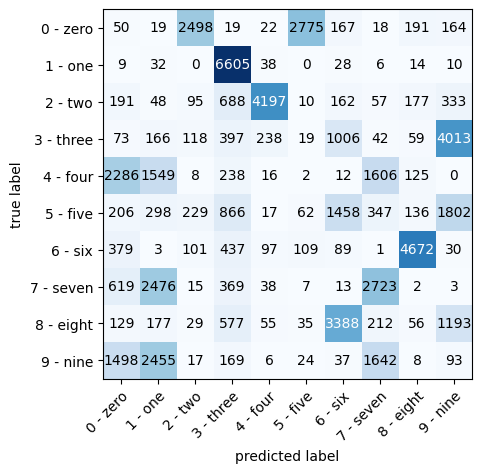

In [417]:
# Plot the confusion matrix for the cluster results and true labels...
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=10)

confusion_matrix_tensor = confusion_matrix(torch.tensor(cluster_labels), torch.tensor(label))

fig, ax = plot_confusion_matrix(confusion_matrix_tensor.numpy(), 
                                class_names=test_data.classes)

### Method 2: Dimensionality Reduction Method (like t-sne and PCA [try both and see how they perform]) on the MNIST Image Dataset and then pass it through the K-Means Clustering to classify the Data

In [10]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2)

# np.vstack([(data.numpy()) for data in image_data]).shape
X_embedded = tsne.fit_transform(np.vstack([data.numpy() for data in image_data]))

In [ ]:
# `X_embedded` is the tsne embedded data....now we pass this low-dimension reduced tsne-embedded-data into the K-Means.... and check the MNIST data classification...

In [418]:
# Now we will cluster this data with K-Means Clustering and GMM(Gaussian Mixture Models)
cluster_labels = kmeans.fit_predict(X_embedded)
cluster_centers = kmeans.cluster_centers_

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm_labels = gmm.fit_predict(X_embedded)

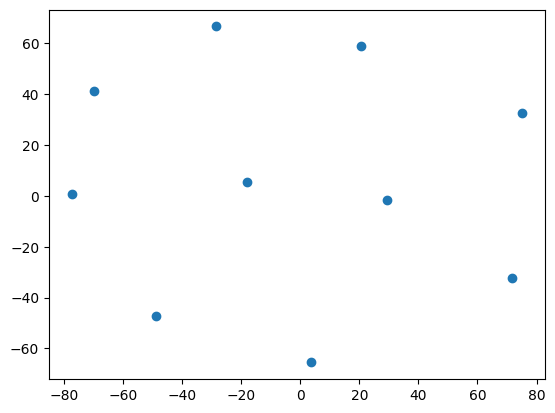

In [419]:
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1])

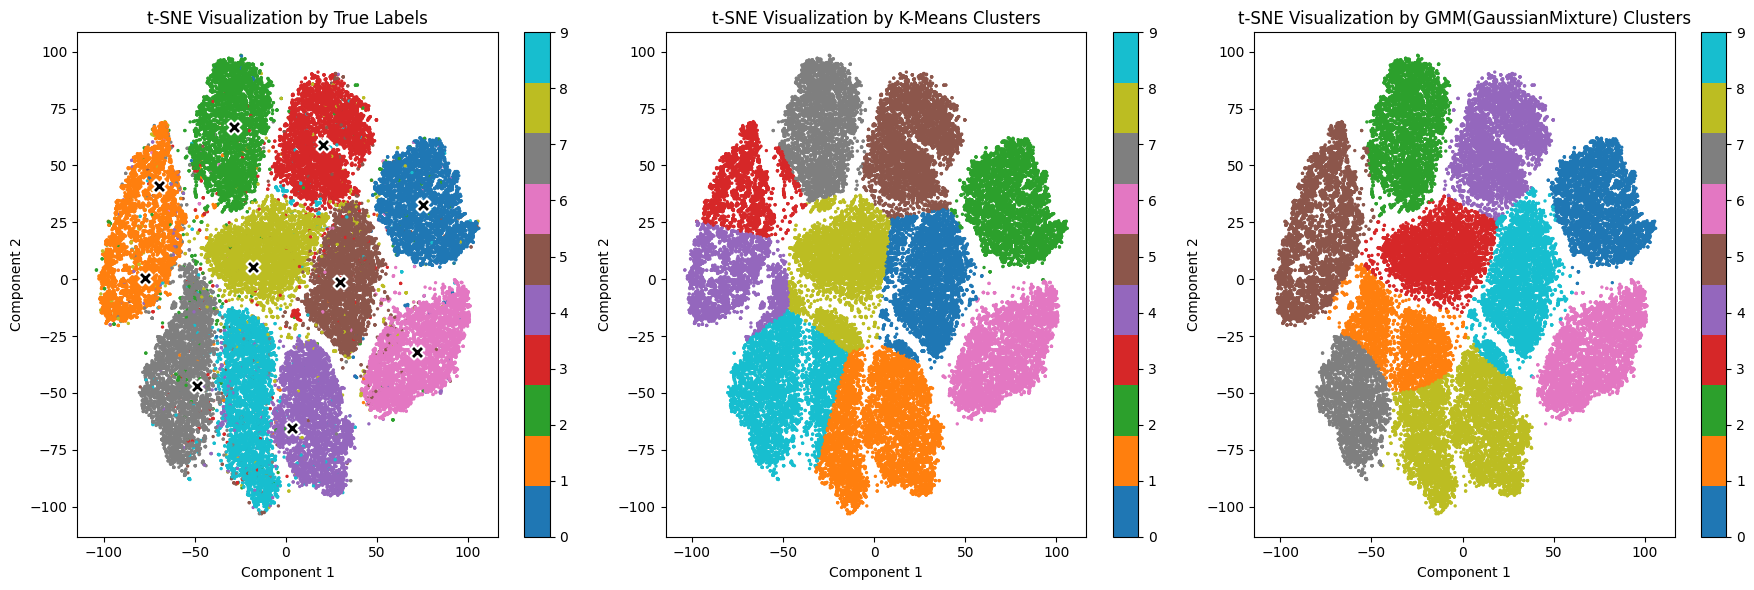

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

scatter1 = axes[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=label, cmap='tab10', s=2)
axes[0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='X', s=100, edgecolor='white', linewidth=1.5, label='Centers')
axes[0].set_title('t-SNE Visualization by True Labels')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')

scatter2 = axes[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='tab10', s=2)
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='X', s=100, edgecolor='white', linewidth=1.5, label='Centers')
axes[1].set_title('t-SNE Visualization by K-Means Clusters')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')

scatter3 = axes[2].scatter(X_embedded[:, 0], X_embedded[:, 1], c=gmm_labels, cmap='tab10', s=2)
axes[2].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='X', s=100, edgecolor='white', linewidth=1.5, label='Centers')
axes[2].set_title('t-SNE Visualization by GMM(GaussianMixture) Clusters')
axes[2].set_xlabel('Component 1')
axes[2].set_ylabel('Component 2')

cbar = plt.colorbar(scatter1)
cbar = plt.colorbar(scatter2)
cbar = plt.colorbar(scatter3)




plt.tight_layout()
plt.show()


In [ ]:
##### How AMI score works is .....
# 📌 Real-world analogy:
# Suppose you grouped animals into 3 clusters:
# Cluster A: cat, dog
# Cluster B: cow, goat
# Cluster C: tiger, lion

# If someone else labeled them:
# Cluster X: dog, cat
# Cluster Y: lion, tiger
# Cluster Z: goat, cow

# Even though the labels (A, B, C vs. X, Y, Z) don’t match, AMI would give a perfect score, because the groupings are structurally identical.

In [ ]:
# -----------------------------------------------
# NOTE: Evaluating Clustering Without Label Mapping
# -----------------------------------------------
# KMeans (and other clustering algorithms) assign arbitrary cluster labels.
# That means:
#     - Cluster 0 might contain all digit 7s
#     - Cluster 1 might contain all digit 3s
# But their assigned labels (0, 1, ...) do NOT correspond to the true digit labels.

# If we want to evaluate how well clustering grouped similar data points
# (regardless of which cluster number they were assigned), we should use:

# --> AMI (Adjusted Mutual Information)
#     - It compares the *structure* of the clusters with the true labels
#     - Ignores label mismatches (e.g., cluster 2 vs. digit 2 doesn't have to match)
#     - Perfect AMI = 1.0 if clustering exactly grouped data by class, even if labels differ

# In contrast:
# --> Accuracy requires us to first match cluster labels to true labels
#     (e.g., via Hungarian algorithm) to make a fair comparison.

# TL;DR:
#     - Use AMI to measure how well clustering grouped the data
#     - Use Accuracy only after remapping cluster labels to match true labels


In [353]:
from sklearn.metrics import adjusted_mutual_info_score

kmeans_ami_score = adjusted_mutual_info_score(labels_true=label, labels_pred=cluster_labels)
kmeans_ami_score

0.7905661193071691

In [354]:
gmm_ami_score = adjusted_mutual_info_score(labels_true=label, labels_pred=gmm_labels)
gmm_ami_score

0.8827433462604706

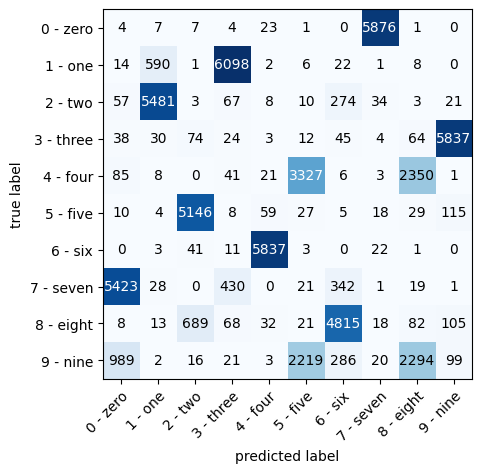

In [355]:
# true labels vs k-means clustered classification
# as discussed earlier... just like accuracy confusion matrix are not good judge of how well the clustering worked...
# although we could take a look at these dark spots in the conf-matrix and know that these represnt one big cluster when plotted....
confusion_matrix_tensor = confusion_matrix(torch.tensor(cluster_labels), torch.tensor(label))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.numpy(), class_names=test_data.classes)

In [ ]:
# Now we will do this same clustering for classifiaction using Autoencoder.....


# then move to more larger and complicated dataset using AutoEnocder and variationsl autoencoder..

In [421]:
### Build an AutoEncoder

class Encoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder_block = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=128),
            nn.ReLU(),
            
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=12),
            nn.ReLU(),

            nn.Linear(in_features=12, out_features=2),
        )

    
    def forward(self, x):
        return self.encoder_block(x)
    

class Decoder(nn.Module):
    def __init__(self, output_shape):
        super().__init__()

        self.decoder_block = nn.Sequential(
            nn.Linear(in_features=2, out_features=12),
            nn.ReLU(),

            nn.Linear(in_features=12, out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.decoder_block(x)

In [422]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = Encoder(input_shape=input_shape)
        self.decoder = Decoder(output_shape=input_shape)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [423]:
autoEncoder = AutoEncoder(input_shape=28*28).to(device)

In [424]:
# Create dataloaders

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [425]:
# Initialize loss function, optimizer

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoEncoder.parameters(), lr=0.001)

In [426]:
num_epochs = 3
for epoch in range(num_epochs):
    autoEncoder.train()
    print('____________________________________________')
    print(f'EPOCHS: {epoch+1}')

    total_loss = 0

    for index, (image, label) in (enumerate(tqdm(train_dataloader))):
        image = image.to(device)
        image = image.view(image.shape[0], -1)

        encoded, decoded = autoEncoder(image)

        loss = loss_fn(decoded, image)
        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Total Loss: {total_loss/len(train_dataloader)}')

____________________________________________
EPOCHS: 1


100%|██████████| 1875/1875 [00:22<00:00, 82.37it/s] 


Total Loss: 0.06008019670844078
____________________________________________
EPOCHS: 2


100%|██████████| 1875/1875 [00:18<00:00, 98.97it/s] 


Total Loss: 0.04947609454393387
____________________________________________
EPOCHS: 3


100%|██████████| 1875/1875 [00:24<00:00, 76.74it/s] 

Total Loss: 0.04557306692004204


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

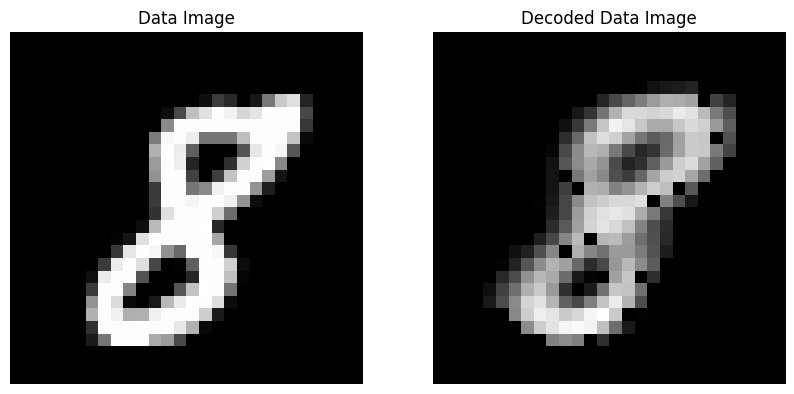

In [434]:
# Generate random integer
rand_int = torch.randint(0, len(train_data)-1, (1,)).item()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# index random data corresponding to the integer
image = train_data[rand_int][0]

# plot the data image
axes[0].imshow(image.permute(1, 2, 0), cmap='gray')
axes[0].set_title('Data Image')
axes[0].axis(False)

# run inference of data on the trained model and get the decoded data
encoded, decoded = autoEncoder(image.view(image.shape[0], -1).to(device))
decoded = decoded.reshape(image.shape).detach().cpu()

# plot the decoded data image
axes[1].imshow(decoded.permute(1, 2, 0), cmap='gray')
axes[1].set_title('Decoded Data Image')
axes[1].axis(False)

In [435]:
with torch.inference_mode():
    autoEncoder.eval()

    encoded_data = []
    label_data = []

    for index, (image, label) in enumerate(tqdm(train_dataloader)):
        image = image.to(device)
        image = image.view(image.shape[0], -1)
        
        encoded = autoEncoder.encode(image)
        encoded_data += encoded
        label_data += label

encoded_data =  torch.stack(encoded_data).detach().cpu()
label_data = torch.stack(label_data)

100%|██████████| 1875/1875 [00:11<00:00, 159.62it/s]


In [436]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans_cluster = kmeans.fit_predict(encoded_data)
cluster_centers = kmeans.cluster_centers_

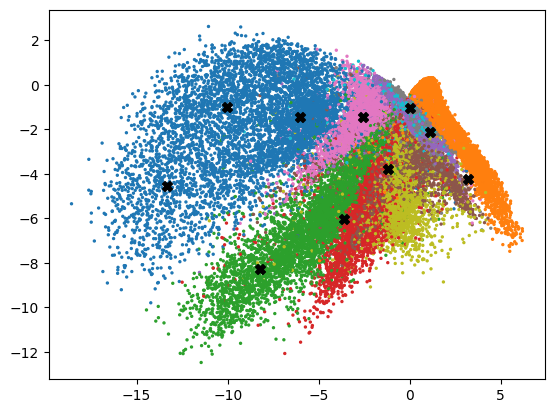

In [449]:
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=label_data, cmap='tab10', s=2)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='X', s=50, label='Centers')

In [ ]:
### Currently the AutoEncoder Model is just trained to get the high-dim MNIST dataset into low dimension latent represent and reconstruct the image form it.....
### It isn't cluster aware....so we will train it to be aware of cluster.....train it to group the 'latent representation' in cluster 

# (Cluster-Aware Training (recon + clustering loss))

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):

    autoEncoder.train()

    print('_______________________________')
    print(f'EPOCH: {epoch+1}')

    total_loss = 0

    for image, label in train_dataloader:
        image = image.view(image.shape[0], -1).to(device)
        encoded, decoded = autoEncoder(image)

        recon_loss = loss(decoded, image)

        
        # cluster_loss = loss()
        break
    break

_______________________________
EPOCH: 1


In [ ]:
nn.MSELoss()

The general process/outline for this project.

* Will be using DEC (Deep Embedding for Clustering). This will make use of (tinyVgg model architecture) that also combines auto encoders to cluster the images into the labels.




1. Install the necessary libraries (abviously) such as torch, torchvision, matplotlib, numpy

# Make an autoencoder

In [ ]:
# Initialize the loss function, optimizer and the scheduler

from torch.optim import lr_scheduler

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_autoencoder.parameters(),
                            lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)



In [ ]:
# Train our autoencoder model

num_epochs = 5

# list of loss for each epochs so we can compare it later in graph
loss_for_graph = []


for epoch in range(num_epochs):
    model_autoencoder.train()

    train_loss = 0
    
    
    
    for index, (image, label) in enumerate(train_dataloader):

        image, label = image.to(device), label.to(device)


        image = image.view(image.shape[0], -1) # .view() is used to reshape tensor in python. the resulting number of values is preserved in the .view(). -1 is used as input parameter in the case to let the python decide what dimension make sense to put there as to preserve the total number of values in the resulting tensor. say i have an tensor of shape (3, 100, 100, 75) and then i put the `.view(3, -1)` then the python would reshape it into the (3, 100*100*75) which is shape (3, 750000)


        model_output = model_autoencoder(image)

        loss = loss_fn(model_output[1], image)

        train_loss += loss

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % 250 == 0:
            print(f'{index+1}/{len(train_dataloader)}')
        
    scheduler.step()
    
    train_loss /= len(train_dataloader)

    loss_for_graph.append(train_loss.item())

    print(f'Epoch: {epoch} | Loss: {train_loss:.4f}')


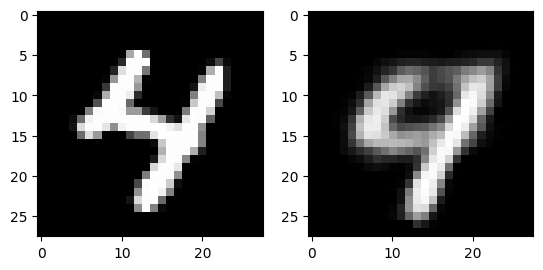

In [ ]:
# print out the output of our autoencoder when an image is passed thorugh it
import random 
rand_int = random.choice(range(len(train_data)))

image, label = train_data[rand_int]

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), cmap='grey')

image = image.view(image.shape[0], -1)
output = model_autoencoder(image.to(device))
output = output[1].reshape(1, 28, 28)
output = output.detach().cpu()

plt.subplot(1, 2, 2)
plt.imshow(output.permute(1, 2, 0), cmap='grey')


In [ ]:
# Get all the encoded output for all of our input images
# Also get the labels of images, so we can compare the accuracy of the model as it classifies the latent representation of the model(unsupervised learning) into the labels

with torch.inference_mode():
    model_autoencoder.eval()

    encoded_data = []
    label_data = []
    for image, label in train_dataloader:
        image = image.to(device)
        image = image.view(image.shape[0], -1)

        encoded_batch = model_autoencoder(image)[0].detach().cpu()
        # print(encoded_batch.shape)
        encoded_data += encoded_batch
        label_data += label
       
encoded_data = torch.stack(encoded_data)
label_data = torch.stack(label_data)

encoded_data.shape, label_data.shape


(torch.Size([60000, 3]), torch.Size([60000]))

In [ ]:
# apply kmeans clustering on our encoded 

from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)

cluster_labels = kmeans.fit_predict(encoded_data)

In [ ]:
# Get the ami(adjusted mutual info) score for the clustering

from sklearn.metrics import adjusted_mutual_info_score

ami_score = adjusted_mutual_info_score(label_data, cluster_labels)

print(f'{ami_score:.2f}')

0.48


In [ ]:
cluster_labels = torch.tensor(cluster_labels)

In [ ]:
cluster_labels

tensor([8, 1, 0,  ..., 6, 2, 6], dtype=torch.int32)